# Import things

In [1]:
import os
from glob import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import (Input, Dense, Dropout,
                                     Activation, Flatten, Conv2D,
                                     MaxPooling2D, BatchNormalization,
                                     GlobalAveragePooling2D)
from tensorflow.keras.utils import plot_model

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Check GPU
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# List Training Data

In [3]:
train_dict={'file_name': [], 'type': []}

# 只拿 train 資料中的 .jpg 檔案
for i in glob('/kaggle/input/*/train/*/*.jpg'):
    train_dict['file_name'].append(i)
    # 字串處理取出檔案名稱前三個字元來判斷類別
    train_dict['type'].append(i.split('/')[-2])

In [4]:
# get the mapping of class name: class id

mapping_fname = glob("/kaggle/input/**/mapping.txt", recursive=True)[0]

mapping_dict = pd.read_csv(
    mapping_fname,
    header=None,
    index_col=0).to_dict()[1]

print(mapping_dict)

{'CALsuburb': 9, 'PARoffice': 7, 'bedroom': 12, 'coast': 10, 'forest': 4, 'highway': 14, 'industrial': 2, 'insidecity': 3, 'kitchen': 0, 'livingroom': 5, 'mountain': 8, 'opencountry': 6, 'store': 11, 'street': 1, 'tallbuilding': 13}


In [5]:
train_df = pd.DataFrame(train_dict)
train_df["type"] = train_df.type.map(mapping_dict)
train_df.head(3)

,file_name,type
0,/kaggle/input/aia-xt122-cv-kaggle/train/inside...,3
1,/kaggle/input/aia-xt122-cv-kaggle/train/inside...,3
2,/kaggle/input/aia-xt122-cv-kaggle/train/inside...,3


# Data Inspection

<Axes: >

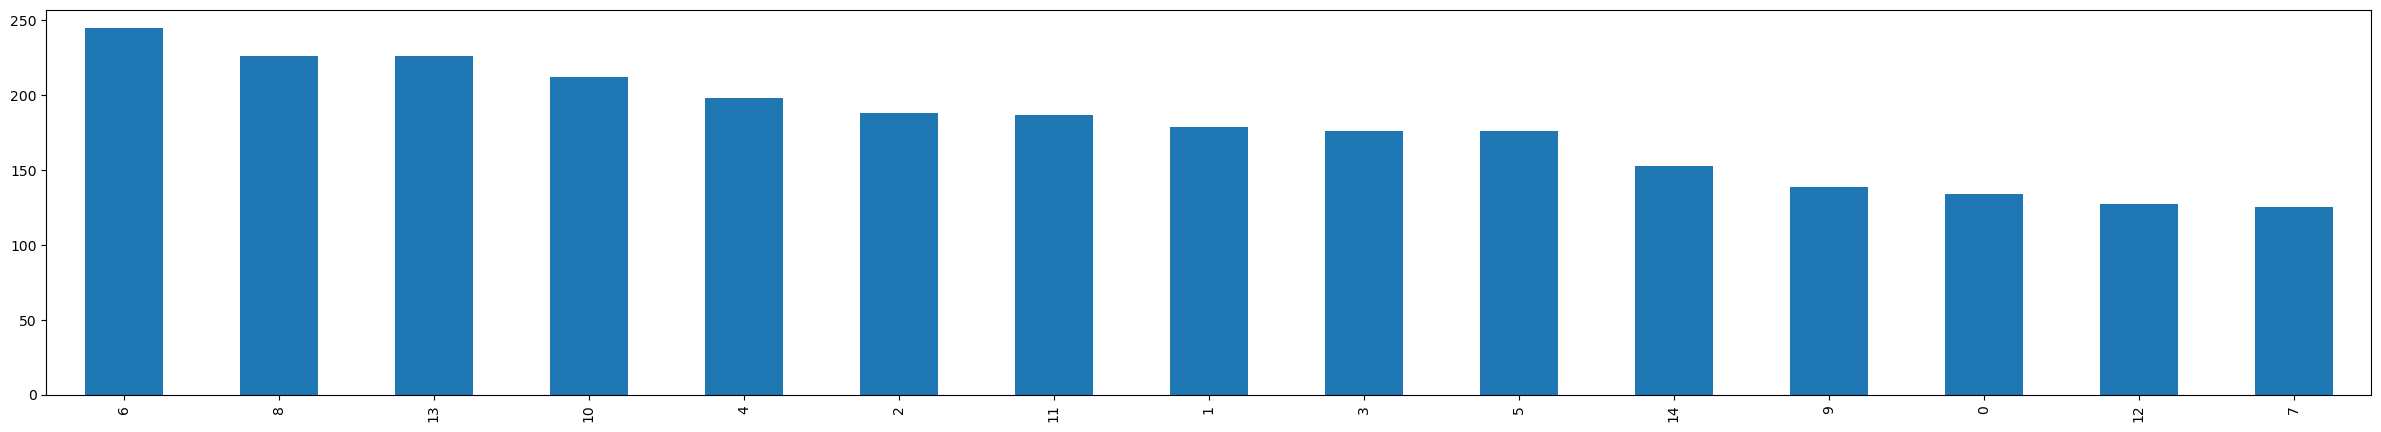

In [6]:
# 看一下有沒有不平衡
plt.figure(figsize=(30, 5))
train_df.type.value_counts().plot.bar()
# 看起來是還好，出問題再依照這個distribution調整

In [7]:
# Splitting
from sklearn.model_selection import train_test_split
# train_df = train_df.sample(len(train_df))
File_ = train_df.file_name.values.copy()
y_ = train_df.type.values.copy()

File_train, File_val, y_train, y_val, = train_test_split(File_, y_, test_size=0.1,stratify=y_)
print(len(train_df),len(y_train),len(y_val))

2691 2421 270


# Build Training Data Loader

In [8]:
NUM_CLASSES = len(mapping_dict.keys())

def my_preprocess (path, label): # 前處裡程式 
    image = tf.io.read_file (path)
    image = tf.image.decode_jpeg (image, channels=3)
    image = tf.image.resize (image, [224, 224])/255.
    return image, tf.one_hot(label, depth=NUM_CLASSES) # Y那邊做 one-hot

train_ds = tf.data.Dataset.from_tensor_slices((File_train, y_train))
train_ds = train_ds.map(my_preprocess)

val_ds = tf.data.Dataset.from_tensor_slices((File_val, y_val))
val_ds = val_ds.map(my_preprocess)

In [9]:
# inspect output
for x, y in train_ds:
    print(x.shape)
    print(x.numpy().max(),x.numpy().min())
    print(y.shape)
    break

(224, 224, 3)
0.9683269 0.0065431367
(15,)


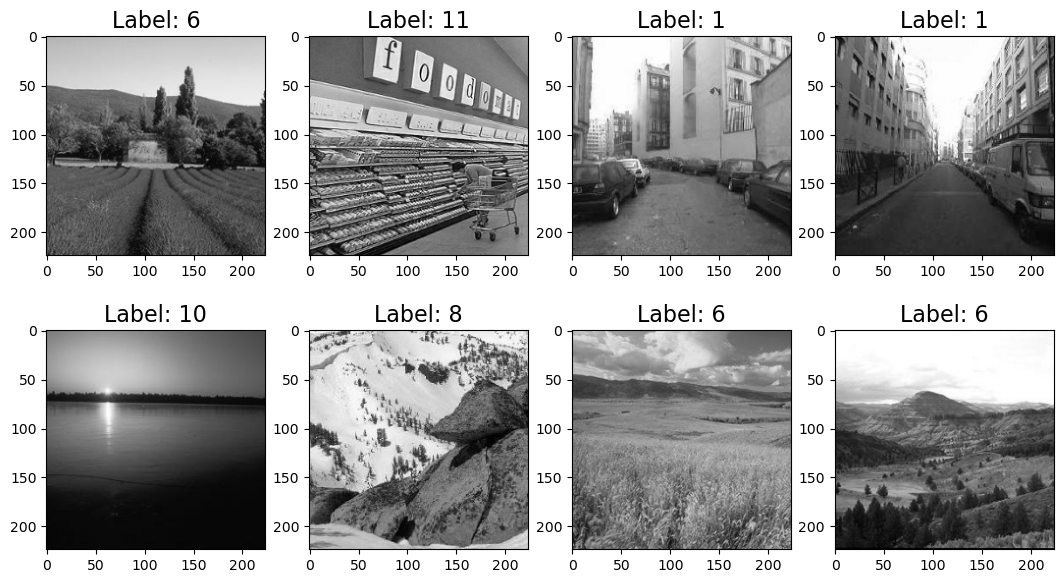

In [10]:
# 畫圖
def my_plot(datas):
    plt.figure(figsize=(13, 7))
    for i,data in enumerate(datas):
        plt.subplot(2, 4, i+1)
        plt.imshow(data[0].numpy())
        plt.title("Label: {}".format(list(data[1]).index(1)), fontsize=16)
    plt.show()
my_plot(train_ds.take(8))

# 資料擴增

## 圖像數值調整使用 tf.image
- 圖像數值：亮度、對比度、色調、飽和度、品質、翻轉

## 圖像形狀調整使用 tf.keras.layers
- 圖像形狀：剪裁、翻轉、旋轉、縮放、高度、寬度

In [11]:
# def aug1(image):
#     # 亮度
#     image = tf.image.random_brightness(image, 
#                                        max_delta=0.2)
#     # 對比度
#     image = tf.image.random_contrast(image,
#                                      lower=0.5,
#                                      upper=1)
#     # 色調
#     image = tf.image.random_hue(image,
#                                 max_delta=0.4)
#     # 飽和度 X
# #     image = tf.image.random_saturation(image,
# #                                        lower=1,
# #                                        upper=5)
#     image = tf.image.resize (image, [224, 224])
    
#     return image

In [12]:
aug2 = tf.keras.Sequential(
    [        
#         # 翻轉
#         layers.RandomFlip("horizontal"),

        # 隨機縮放
#         layers.RandomZoom(height_factor = (-0.2, 0.2),
#                           width_factor = (-0.2, 0.2),
#                           fill_mode = "nearest"),
        # 隨機平移
        layers.RandomTranslation(height_factor = (-0.1, 0.1),
                          width_factor = (-0.1, 0.1),
                          fill_mode = "nearest"),
        
        # 統一大小
        layers.Resizing(224, 224),
    ]
)

(224, 224, 3)
0.9483588 0.027620409


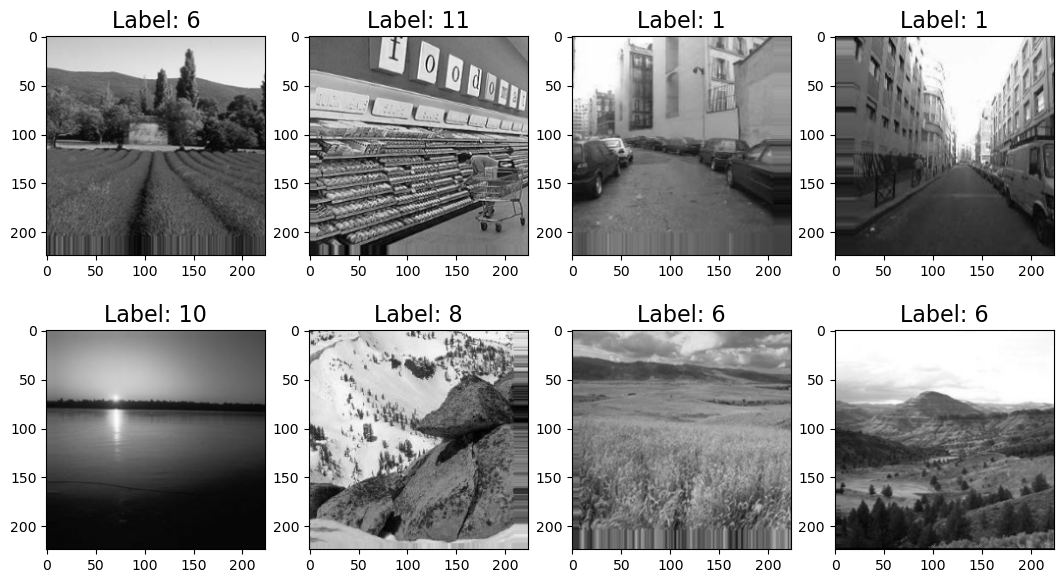

In [13]:
train_ds_aug = train_ds.map(
    lambda x, y: (aug2(x), y) 
)
for x, y in train_ds_aug:
    print(x.shape)
    print(x.numpy().max(),x.numpy().min())
    break
my_plot(train_ds_aug.take(8))

# Model Construction

In [14]:
SHAPE = [224, 224, 3]
NUM_CLASSES = len(mapping_dict.keys())

inputs = Input(shape=SHAPE)

x = Conv2D(32, (3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [15]:
model_dir = 'model-logs/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = f'{model_dir}{model.__class__.__name__}'

modelfiles = f'{model_dir}basic_model-best-model.h5'
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=5,
                                          verbose=1)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=10,
                                          verbose=1)


callbacks_list = [model_mckp, lr_scheduler, earlystop]

In [16]:
# 編譯模型
# 選用 Adam 為 optimizer
learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [17]:
BATCH_SIZE = 32
EPOCHS = 40
history = model.fit(train_ds_aug.shuffle(len(train_ds)).batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=val_ds.cache().batch(BATCH_SIZE),
                    callbacks=callbacks_list)

Epoch 1/40
76/76 [==============================] - 36s 144ms/step - loss: 10.6567 - accuracy: 0.1958 - val_loss: 2.8745 - val_accuracy: 0.0778 - lr: 1.0000e-04
Epoch 2/40
76/76 [==============================] - 20s 82ms/step - loss: 2.1720 - accuracy: 0.3114 - val_loss: 3.3482 - val_accuracy: 0.0778 - lr: 1.0000e-04
Epoch 3/40
76/76 [==============================] - 19s 86ms/step - loss: 1.9792 - accuracy: 0.3627 - val_loss: 3.9956 - val_accuracy: 0.0778 - lr: 1.0000e-04
Epoch 4/40
76/76 [==============================] - 19s 85ms/step - loss: 1.8551 - accuracy: 0.4143 - val_loss: 4.0605 - val_accuracy: 0.0741 - lr: 1.0000e-04
Epoch 5/40
76/76 [==============================] - 23s 133ms/step - loss: 1.7310 - accuracy: 0.4577 - val_loss: 3.3845 - val_accuracy: 0.1370 - lr: 1.0000e-04
Epoch 6/40
76/76 [==============================] - 22s 124ms/step - loss: 1.6207 - accuracy: 0.4833 - val_loss: 2.4546 - val_accuracy: 0.2333 - lr: 1.0000e-04
Epoch 7/40
76/76 [========================

In [18]:
best_model = "./model-logs/basic_model-best-model.h5"
model = load_model(best_model)

In [19]:
y_pred = model.predict(val_ds.map(lambda x, y: x).batch(32))
y_pred = y_pred.argmax(-1)

9/9 [==============================] - 1s 88ms/step


In [20]:
class_names = np.array([each for each in mapping_dict.keys()])

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.6333333333333333
[[ 6  0  0  0  0  3  0  0  0  0  0  2  1  1  0]
 [ 0 11  1  0  0  0  0  1  0  2  0  2  0  0  1]
 [ 0  1 10  2  0  0  0  0  0  0  0  2  0  4  0]
 [ 0  0  3 10  1  2  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0 18  0  0  0  2  0  0  0  0  0  0]
 [ 0  1  2  0  0  7  0  1  0  1  0  3  2  1  0]
 [ 0  1  1  0  0  0 19  0  2  0  1  0  0  0  0]
 [ 1  0  1  1  0  2  0  5  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  0  5  0 16  0  0  0  0  1  0]
 [ 0  0  1  0  0  0  0  0  0 12  0  0  0  1  0]
 [ 0  0  0  0  0  0  5  0  1  0 12  0  0  0  3]
 [ 0  0  0  3  0  0  0  0  1  0  0 14  0  1  0]
 [ 0  0  0  0  0  5  0  0  0  0  0  0  6  2  0]
 [ 0  0  3  2  0  0  0  1  1  0  0  3  0 13  0]
 [ 0  0  1  0  0  0  2  0  0  0  0  0  0  0 12]]


In [22]:
all_ds = tf.data.Dataset.from_tensor_slices((File_, y_))
all_ds = all_ds.map(my_preprocess)
# all_ds_aug = train_ds.map(lambda x, y: (aug2(x), y))

history = model.fit(all_ds.shuffle(len(all_ds)).batch(BATCH_SIZE),
                    epochs=3,
                    callbacks=callbacks_list)

Epoch 1/3
85/85 [==============================] - 14s 82ms/step - loss: 0.5586 - accuracy: 0.8231 - lr: 1.0000e-05
Epoch 2/3
85/85 [==============================] - 11s 79ms/step - loss: 0.5268 - accuracy: 0.8335 - lr: 1.0000e-05
Epoch 3/3
85/85 [==============================] - 10s 80ms/step - loss: 0.4878 - accuracy: 0.8540 - lr: 1.0000e-05


# Predict and Submit

In [23]:
best_model = "./model-logs/basic_model-best-model.h5"
model = load_model(best_model)

In [24]:
sample_submission_fname = glob("/kaggle/input/**/sample_submission.csv", recursive=True)[0]
test_directoy_name = glob("/kaggle/input/**/test", recursive=True)[0]

output_df = pd.read_csv(sample_submission_fname)
test_filenames=[]
for i in output_df.id.values:
    test_filenames.append(f"{test_directoy_name}/{i}.jpg")

In [25]:
def test_preprocess (path): # 前處裡程式 
    image = tf.io.read_file (path)
    image = tf.image.decode_jpeg (image, channels=3)
    image = tf.image.resize (image, [224, 224])/255.
    return image

test_ds = tf.data.Dataset.from_tensor_slices(test_filenames).map(test_preprocess)

In [26]:
# Predict output
test_pred = model.predict(test_ds.batch(BATCH_SIZE)).argmax(-1)

# Put it to the output file

57/57 [==============================] - 5s 80ms/step


In [27]:
output_df['class'] = test_pred
output_df.to_csv('submission_class.csv', index=False)

In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session